<a href="https://colab.research.google.com/github/namanphy/EVA5/blob/main/S5/eva_session5%20-%20iter%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
from torchsummary import summary

## Getting to know our data

In [15]:
train_set = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])


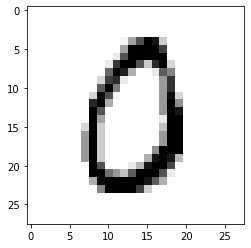

In [18]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_set.train_data
train_data = train_set.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_set.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_set.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

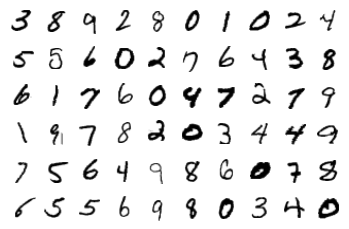

In [19]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Setting up Dataloaders and Transformations


In [20]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [22]:
torch.manual_seed(1)
if use_cuda:
    torch.cuda.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

train_set = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_set = datasets.MNIST('../data', train=False, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_set , batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)


## Making our model

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1, bias=False), # RF - 3x3
            nn.ReLU(), # RF - 3x3
            nn.Conv2d(16, 16, 3, bias=False), # RF - 5x5
            nn.ReLU(), # RF - 5x5
            nn.MaxPool2d(2, 2) # RF - 10x10
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, bias=False), # RF - 12x12
            nn.ReLU(), # RF - 12x12
            nn.Conv2d(32, 32, 3, bias=False), # RF - 14x14
            nn.ReLU(), # RF - 14x14
            nn.MaxPool2d(2, 2) # RF - 28x28
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 10, 5, bias=False) # RF - 30x30
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # x = x.mean(dim=[-2,-1])
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [34]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]           2,304
              ReLU-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 32, 13, 13]           4,608
              ReLU-7           [-1, 32, 13, 13]               0
            Conv2d-8           [-1, 32, 11, 11]           9,216
              ReLU-9           [-1, 32, 11, 11]               0
        MaxPool2d-10             [-1, 32, 5, 5]               0
           Conv2d-11             [-1, 10, 1, 1]           8,000
Total params: 24,272
Trainable params: 24,272
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [38]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    print(f"EPOCH - {epoch}")
    model.train()
    pbar = tqdm(train_loader, position=0, leave=True)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [39]:
data, target = next(iter(train_loader))
print(data.size(), target.size())

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [40]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH - 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.0817924365401268 Batch_id=468 Accuracy=87.92: 100%|██████████| 469/469 [00:11<00:00, 42.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9781/10000 (98%)

EPOCH - 2


Loss=0.07726475596427917 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:10<00:00, 42.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0705, Accuracy: 9768/10000 (98%)

EPOCH - 3


Loss=0.09498169273138046 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:10<00:00, 43.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9860/10000 (99%)

EPOCH - 4


Loss=0.02390933223068714 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:11<00:00, 42.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9874/10000 (99%)

EPOCH - 5


Loss=0.02946111373603344 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:11<00:00, 42.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9879/10000 (99%)

EPOCH - 6


Loss=0.2579311430454254 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:10<00:00, 42.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9892/10000 (99%)

EPOCH - 7


Loss=0.008159344084560871 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:11<00:00, 42.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9880/10000 (99%)

EPOCH - 8


Loss=0.014651179313659668 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 42.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99%)

EPOCH - 9


Loss=0.008155612275004387 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:10<00:00, 43.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9884/10000 (99%)

EPOCH - 10


Loss=0.004961404483765364 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:10<00:00, 42.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9884/10000 (99%)

EPOCH - 11


Loss=0.030162595212459564 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:11<00:00, 42.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9901/10000 (99%)

EPOCH - 12


Loss=0.031126081943511963 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:10<00:00, 43.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9906/10000 (99%)

EPOCH - 13


Loss=0.011505570262670517 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:11<00:00, 41.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9908/10000 (99%)

EPOCH - 14


Loss=0.021272482350468636 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:11<00:00, 42.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9907/10000 (99%)

EPOCH - 15


Loss=0.0001580783718964085 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:11<00:00, 41.32it/s]



Test set: Average loss: 0.0379, Accuracy: 9900/10000 (99%)



Text(0.5, 1.0, 'Test Accuracy')

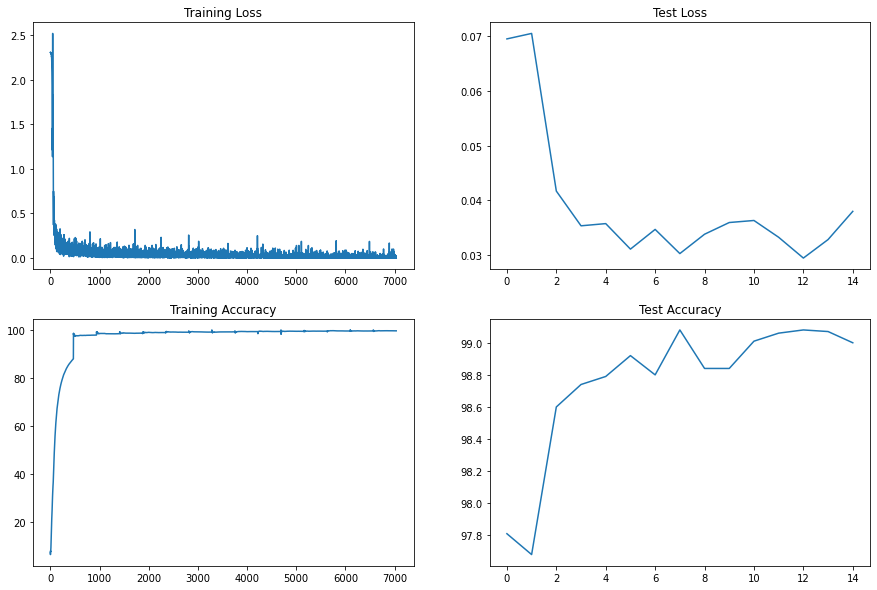

In [41]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")



---


Target
1. Set up the imports, Dataloader, and basic train and test pipeline.
2. Visualise the dataset.
3. Get the basic model up and running and identify the next step.

Results
1. parameters = 24,272
2. Train Accuracy = 99.63
3. Test Accuracy = 99.08

Analysis
1. Good training accuracy to start with only 24,000 parameters and no fancy stuff. The model architecture is somewhat good.
2. Overfitting - It is clear that our basic model is overfitting.
3. Also evident from the graphs that `test loss` is not consistently decreasing.
4. Number of model parameters is actually more than the required target.